# Анализ результатов A/B-тестирования
Нужно проанализировать данные от интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. 
У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.
В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

## Цель исследования — 
провести оценку эффективности новой версии сайта интернет-магазина BitMotion Kit с помощью анализа результатов A/B-теста, определить, в какой степени новая версия способствует увеличению числа пользователей, совершающих покупку, и проверить статистическую значимость выявленных различий между группами.

## Техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты. 
Данные  
https://code.s3.yandex.net/datasets/ab_test_participants.csv — таблица участников тестов. 

Структура файла: 
- user_id — идентификатор пользователя; 
- group — группа пользователя;
- ab_test — название теста; 
- device — устройство, с которого происходила регистрация.

https://code.s3.yandex.net/datasets/ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года; 
Структура файла: 
- user_id — идентификатор пользователя; 
- event_dt — дата и время события; 
- event_name — тип события;
- details — дополнительные данные о событии.

## Загрузка и знакомство с  данными

In [3]:
# Загрузка библиотек
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Создание датафреймов
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [6]:
# Обзор данных
participants.info()
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [8]:
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [9]:
# Проверка наличия дубликатов
print("Дубликаты по user_id в таблице с участниками:")
duplicates = participants[participants.duplicated(subset='user_id', keep=False)]
print(duplicates)
print(len(duplicates))

Дубликаты по user_id в таблице с участниками:
                user_id group                  ab_test   device
1      001064FEAAB631A1     B  recommender_system_test  Android
2      001064FEAAB631A1     A        interface_eu_test  Android
9      00341D8401F0F665     A  recommender_system_test   iPhone
10     00341D8401F0F665     B        interface_eu_test   iPhone
25     0082295A41A867B5     A        interface_eu_test   iPhone
...                 ...   ...                      ...      ...
14490  FF2174A1AA0EAD20     A  recommender_system_test  Android
14495  FF44696E39039D29     B        interface_eu_test      Mac
14496  FF44696E39039D29     A  recommender_system_test      Mac
14522  FFF28D02B1EACBE1     B  recommender_system_test       PC
14523  FFF28D02B1EACBE1     B        interface_eu_test       PC

[1774 rows x 4 columns]
1774


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
    Имеется 1774 дубликата

In [10]:
# Фильтрация: только тест interface_eu_test
test_participants = participants[participants['ab_test'] == 'interface_eu_test']

In [11]:
# Проверка дубликатов в test_participants в тестовых группах
print("Наличие дубликатов после фильтрации по interface_eu_test):")
duplicates_test = test_participants[test_participants.duplicated(subset='user_id', keep=False)]
print(f"Количество дублированных строк: {len(duplicates_test)}")
if len(duplicates_test) == 0:
    print("Дубликатов внутри test_participants нет")
else:
    print("Пример дублированных строк в test_participants:")
    display(duplicates_test.sort_values(by='user_id').head())

Наличие дубликатов после фильтрации по interface_eu_test):
Количество дублированных строк: 0
Дубликатов внутри test_participants нет


## Оценка корректности проведения теста:
 - соответствие требованиям технического задания,
 - равномерность распределения пользователей по группам теста,
 - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [12]:
# Количество пользователей после фильтрации
print(f"Количество пользователей после фильтрации: {len(test_participants)}")

Количество пользователей после фильтрации: 10850


In [13]:
# Разделение по группам
a_group = test_participants[test_participants['group'] == 'A'].value_counts()
b_group = test_participants[test_participants['group'] == 'B'].value_counts()
print(f"Количество пользователей в группе А {len(a_group)}")
print(f"Количество пользователей в группе А {len(b_group)}")

Количество пользователей в группе А 5383
Количество пользователей в группе А 5467


In [14]:
# Проверяем пересечения пользователей между группами с помощью группировки
intersection_count = test_participants.groupby('user_id').agg({'group': 'nunique'}).query('group > 1')
# Выводим результат
if not intersection_count.empty:
    print(f"Количество пользователей, попавших в обе группы: {intersection_count}")
    print("Пользователи в пересечении:")
    print(intersection_count)
else:
    print("Пересечений между группами A и B нет.")

Пересечений между группами A и B нет.


In [15]:
# Статистика по группам
print("Статистика по группам (устройства):")
display(test_participants.groupby('group')['device'].describe())

Статистика по группам (устройства):


,count,unique,top,freq
group,,,,
A,5383,4,Android,2445
B,5467,4,Android,2414


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
- Общее количество наблюдений (count) для группы А - 5383  | для группы В - 5467
- Количество уникальных значений (unique) для группы А и В = 4
- Наиболее часто встречающееся значение (top)для группы А и В - Android
- Частота наиболее популярного значения (freq)для группы А -	2445  | для группы В - 2414

Разница между группами небольшая (~84), что говорит о примерно равных размерах групп.
В обеих группах по 4 уникальных значения, что указывает на одинаковое разнообразие категорий.
В обеих группах наиболее часто встречается Android.
Частоты очень близки: 2445 в группе A и 2414 в группе B
Итог:
На основании этих данных можно сделать вывод, что группы A и B примерно равномерны по размеру и имеют схожие распределения по категориям. Это говорит о хорошей сбалансированности для проведения А/В теста.

##  Анализ  пользовательской активности

In [16]:
# Анализ ативности пользователей
# Оставляем только события пользователей, участвовавших в тесте.
#И исключаем системных пользователей и события, связанные с завершением рекламной кампании
unique_user = test_participants['user_id'].unique()
test_events = events[events['user_id'].isin(unique_user)]
test_events = test_events[test_events['user_id'] != 'GLOBAL']
test_events = test_events[~test_events['event_name'].str.contains('End of Black Friday Ads Campaign')]
test_events = test_events.merge(test_participants,on='user_id', how='left')

#### Горизонт анализа:
рассчитаем время совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации

In [17]:
# 1. Найти дату регистрации для каждого пользователя
registrations = test_events[test_events['event_name'] == 'registration']
# Получаем минимальную дату регистрации для каждого user_id
registration_dates = registrations.groupby('user_id')['event_dt'].min().reset_index()
registration_dates.rename(columns={'event_dt': 'registration_date'}, inplace=True)

# 2. Объединяем с исходными событиями
events_with_reg = events.merge(registration_dates, on='user_id', how='left')

# 3. Рассчитываем лайфтайм (в днях)
events_with_reg['days_since_registration'] = (
    events_with_reg['event_dt'] - events_with_reg['registration_date']
).dt.total_seconds() / (24 * 3600)

# 4. Оставляем только события в первые 7 дней после регистрации
# Исключаем события до регистрации (negative days)
filtered_events = events_with_reg[
    (events_with_reg['days_since_registration'] >= 0) &
    (events_with_reg['days_since_registration'] <= 7)
]

# Теперь в `filtered_events` содержатся только события, произошедшие в первые 7 дней после регистрации

In [18]:
# Подсчет количества событий на пользователя
event_counts = filtered_events.groupby('user_id').size().reset_index(name='event_count')
event_counts = event_counts.merge(test_participants[['user_id', 'group']], on='user_id', how='left')

In [19]:
# Расчет времени активности (разница между первым и последним событием в часах)
user_activity = filtered_events.groupby('user_id').agg(
    first_event=('event_dt', 'min'),
    last_event=('event_dt', 'max')
).reset_index()
user_activity['hours_active'] = (user_activity['last_event'] - user_activity['first_event']).dt.total_seconds() / 3600
user_activity = user_activity.merge(test_participants[['user_id', 'group']], on='user_id', how='left')

In [20]:
# Статистика по количеству событий и времени активности
print("Стат. данные о ко-ве событий в группах:")
display(event_counts.groupby('group')['event_count'].describe())
print("Часы активности по группам:")
display(user_activity.groupby('group')['hours_active'].describe())

Стат. данные о ко-ве событий в группах:


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,5383.0,6.271967,3.074688,2.0,4.0,6.0,8.0,23.0
B,5467.0,6.436254,3.170440,2.0,4.0,6.0,8.0,23.0


Часы активности по группам:


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,5383.0,68.638665,52.885183,0.0,20.319583,65.003333,113.688472,167.969444
B,5467.0,70.286110,53.008337,0.0,22.992500,67.228611,116.375278,167.952778


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
    
Анализ по количеству событий (ко-во событий в группах):
    
    Среднее количество событий на пользователя в группе A — примерно 6.27, в группе B — около 6.44. Стандартные отклонения схожи (~3.07 и ~3.17), что говорит о схожести распределений. Максимальные значения (23) одинаковы, минимальные (2) тоже совпадают.
    
Анализ по времени активности:
    
    Среднее время активности в группе A — около 68.64 часов, в группе B — около 70.29 часов. Стандартные отклонения схожи (~52.89 и ~53.01). Максимальные значения (167.97 часов) одинаковы.

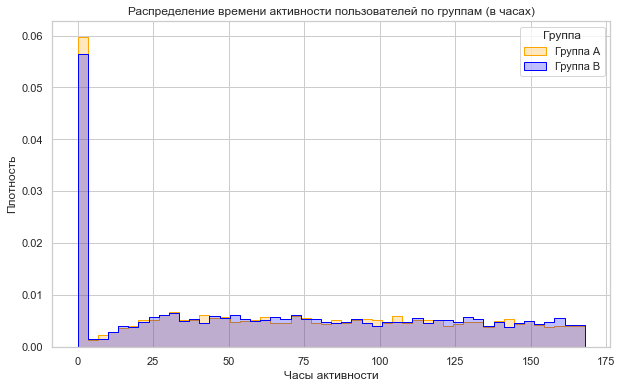

In [21]:
# Визуализация распределения времени активности
# Настройка стиля графика
# Определяем палитру цветов для групп
palette = {
    'A': 'orange',
    'B': 'blue'
}
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
# Построение распределения по группам
sns.histplot(
    data=user_activity,
    x='hours_active',
    hue='group',
    element='step',
    stat='density',
    common_norm=False,
    bins=50,
    palette=palette
)

#Вывод
plt.title('Распределение времени активности пользователей по группам (в часах)')
plt.xlabel('Часы активности')
plt.ylabel('Плотность')
plt.legend(title='Группа', labels=['Группа А', 'Группа В'])
plt.show()


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
Для обеих групп характерна наибольшая плотность распределения около 0 часов активности, в районе 10 часов идет резкий спад и в целом после 25 часов стабильная плотность активности

Необходимо оценить достаточность выборки для получения статистически значимых результатов A/B-теста. 

- Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [24]:
from statsmodels.stats.power import NormalIndPower

In [25]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.3  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")



Необходимый размер выборки для каждой группы: 174


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
    Размер выборки более чем достаточный.

### Рассчитаем  для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [26]:
#Объединение данных: определение регистраций
registrations = events[events['event_name'] == 'registration']
registrations = registrations[['user_id', 'event_dt']]
registrations.columns = ['user_id', 'registration_date']

# Объединение с участниками
participants = participants.merge(registrations, on='user_id', how='inner')

# Определение покупок в течение 7 дней после регистрации
purchases = events[events['event_name'] == 'purchase']
purchases = purchases[['user_id', 'event_dt']]
purchases.columns = ['user_id', 'purchase_date']

# Объединяем с регистрациями
data = participants.merge(purchases, on='user_id', how='left')

# Вычисляем разницу дат
data['registration_date'] = pd.to_datetime(data['registration_date'])
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

# Определяем совершили ли покупку в течение 7 дней
data['made_purchase'] = ((data['purchase_date'] - data['registration_date']).dt.days <= 7) & (data['purchase_date'].notnull())

# Группировка по группам теста
grouped = data.groupby('group').agg(
    total_registrations=('user_id', 'count'),
    total_purchases=('made_purchase', 'sum')
).reset_index()

# Расчет конверсии
grouped['conversion_rate'] = grouped['total_purchases'] / grouped['total_registrations']

print(grouped)

  group  total_registrations  total_purchases  conversion_rate
0     A                12129             5013         0.413307
1     B                10925             4641         0.424805


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
Группа A имеет больше регистраций (примерно на 1200 больше), чем группа B.
Разница в размере групп небольшая, что хорошо для сравнения.
Конверсия:
Группа B показывает чуть более высокий показатель конверсии (42,48%) по сравнению с группой A (41,33%).
Разница небошальшая.
Итоговые выводы:
Распределение регистраций и покупок между группами достаточно сбалансировано, хотя группа A немного больше по численности.
Группа B показывает чуть более высокую конверсию, что может свидетельствовать о более успешной стратегии или особенностях тестируемого изменения.
Для окончательных выводов необходимо провести тест , чтобы определить значимость разницы.

## Проводим оценку результатов A/B-тестирования


In [28]:
# Разделение по группам
#a_group = test_participants[test_participants['group'] == 'A'].value_counts()
# b_group = test_participants[test_participants['group'] == 'B'].value_counts()
# H0 Среднее время активности пользователей в группе B не больше, чем в группе A (B ≤ A).
# H1 Среднее время активности пользователей в группе B больше, чем в группе A (B > A).

u_stat, p_value = stats.mannwhitneyu(a_group, b_group, alternative='less')
test_name = "U-тест Манна-Уитни"

# Вывод результатов теста
print(f"Результаты {test_name}:")
display(pd.DataFrame({
    'Статистика': [u_stat],
    'p-value': [p_value]
}, index=['Результат']))

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print(f"P-value < {alpha}: Отвергаем нулевую гипотезу: среднее время активности в группе B больше, чем в группе A.")
else:
    print(f"P-value >= {alpha}: Не отвергаем нулевую гипотезу: нет доказательств, что среднее время активности в группе B больше, чем в группе A.")

Результаты U-тест Манна-Уитни:


,Статистика,p-value
Результат,14714430.5,1.0


P-value >= 0.05: Не отвергаем нулевую гипотезу: нет доказательств, что среднее время активности в группе B больше, чем в группе A.


<div style="background-color: white; border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block; color: black;">
    
Итоговые выводы: 

Нет достаточных оснований утверждать, что новая версия сайта (группа B) значительно улучшает показатели активности или конверсии по сравнению с текущей версией (группа A). Различия между группами являются статистически незначимыми. В целом, новая версия сайта не показала существенного преимущества в ключевых метриках на данном этапе тестирования.

Рекомендация:
Продолжить мониторинг и при необходимости провести дополнительные тесты или анализы для более точной оценки эффективности изменений.